In [1]:
# Import general utilities
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import seaborn as sns
import pandas as pd

# Import TDA utilities
from ripser import ripser
import persim
from persim import plot_diagrams
from persim import landscapes
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
data=np.loadtxt("Trifolium.txt",delimiter="\t")

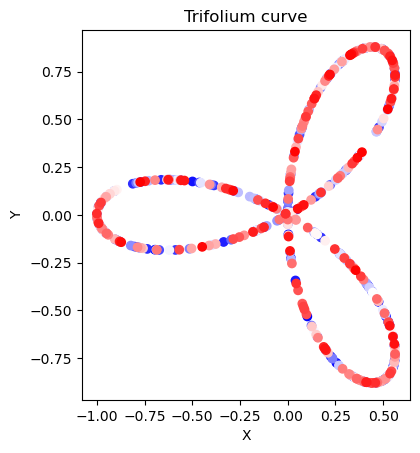

In [31]:
color = cm.bwr(np.linspace(0, 1, data.shape[0]))

plt.scatter(data[:,0],data[:,1],c=color)
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('scaled')
plt.title('Trifolium curve')
plt.show()

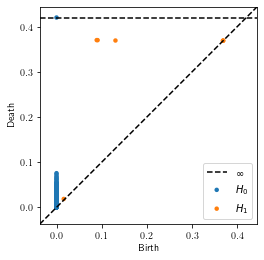

In [4]:
results = ripser(data)
plot_diagrams(results['dgms'], show=True)

In [32]:
def EDist(p1,p2):
    return(math.hypot(p2[0] - p1[0], p2[1] - p1[1]))

In [33]:
def function_dmat(data,rad):
    tree = KDTree(data, leaf_size=2) 
    distlist=[]
    for p in range(data.shape[0]):
        pNeighbours=data[np.setdiff1d(tree.query_radius(data[p:p+1], r=rad)[0],[p]).tolist()]
        N=pNeighbours.shape[0]
        dist=[[0 for i in range(N)] for j in range(N)]
        for pi in range(N):
            ppi=EDist(data[p],pNeighbours[pi])
            for pj in range(pi+1, N):
                dm=EDist(pNeighbours[pi],pNeighbours[pj])
                ppj=EDist(data[p],pNeighbours[pj])
                dm=min(dm, 2*rad-ppi-ppj)
                dist[pi][pj]=dm
                dist[pj][pi]=dm
        distlist.append(np.asarray(dist))
    
    return(distlist)

In [16]:
rb=1
dlist=function_dmat(data,rb)

In [17]:
ripser_diagrams=[]
ripser_landscapes=[]
stepcount=1000
alpha_landscaper = landscapes.PersistenceLandscaper(hom_deg=1, start=0, stop=rb, num_steps=stepcount, flatten=True)
for k in range(data.shape[0]):
    ripser_diagrams.append(ripser(dlist[k], distance_matrix=True))
    if ripser_diagrams[k]['dgms'][1].size!=0:
        ripser_landscapes.append(alpha_landscaper.fit_transform(ripser_diagrams[k]['dgms']))
    else:
        ripser_landscapes.append(np.zeros(stepcount))

In [18]:
w=np.max([x.size for x in ripser_landscapes])
ripser_ls = np.zeros((data.shape[0], w))
for k in range(data.shape[0]):
    ripser_ls[k, 0:len(ripser_landscapes[k])] = ripser_landscapes[k]

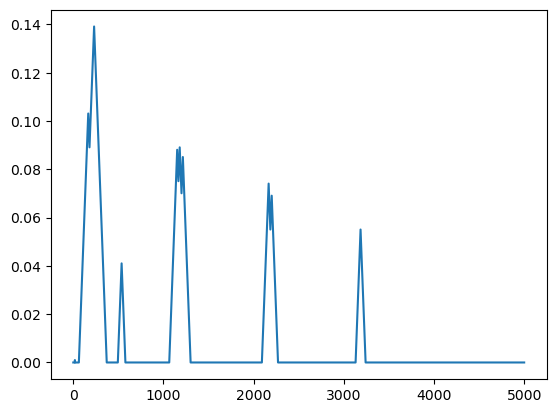

In [19]:
n=0
#dlist[n]
#sns.heatmap(dlist[n])
#plot_diagrams(ripser_diagrams[n]['dgms'],show=True)
plt.plot(ripser_ls[n])

In [34]:
df = pd.DataFrame(ripser_ls)
df1 = df.fillna(0)
df2 = df1.subtract(df1.mean())
pca = PCA(n_components=0.95, svd_solver = 'full')
pca.fit(df2)
df3 = pd.DataFrame(pca.fit_transform(df2))
df4 = df3.fillna(0)
df5 = (df4-df4.mean())/df4.std()
pca.explained_variance_ratio_.cumsum()

array([0.83669426, 0.93335718, 0.96316095])

In [69]:
scores = TSNE(n_components=1, perplexity=30.0).fit_transform(ripser_ls)
smin=np.min(scores)
smax=np.max(scores)
nscore_color=cm.bwr([(x[0]-smin)/(smax-smin) for x in scores])

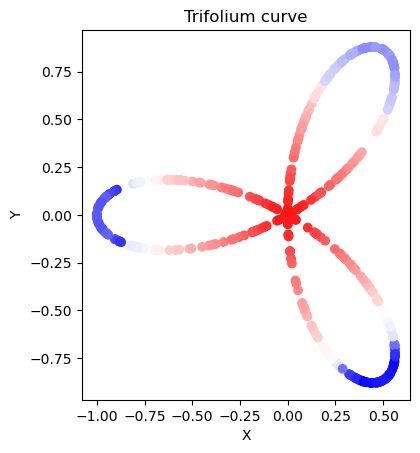

In [70]:
plt.scatter(data[:,0],data[:,1],c=nscore_color)
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('scaled')
plt.title('Trifolium curve')
plt.show()